In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

In [2]:
%matplotlib notebook

# Test 1 dataset

In [5]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


# Set responsivity params

In [3]:
responsive_test = 'ROC'
responsive_thr = 0.05
n_stds = None


# Get aggregated data

In [51]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
trace_type = optsE.trace_type
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [5]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']=='blobs']

In [6]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-ROC-thr-0.05


# Create output dir for classification

In [7]:
outdir = os.path.join(aggregate_dir, 'blob-classification', stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-ROC-thr-0.05


In [8]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [9]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [18]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

stimdf = sdf[sdf['morphlevel'] != -1]

... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:999: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


... offset: 608.72
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')


In [53]:
sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                      index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
sample_data = sample_data[rois_plot]
sample_labels = np.array(sample_data.index.tolist())


In [56]:
sample_labels = np.array(sample_data.index.tolist())


In [57]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

In [10]:

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [11]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))
print(os.path.join(outdir, 'sessions'))

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-ROC-thr-0.05/sessions


# Get aggregate stats

In [58]:
experiment_type = 'blobs'
aggr_tcourse_dir = os.path.join(aggregate_dir, 'data-stats', 'experiment-objects', experiment_type)
aggr_stats_dir = os.path.join(aggregate_dir, 'data-stats', stats_desc)

if not os.path.exists(aggr_tcourse_dir):
    os.makedirs(aggr_tcourse_dir)
if not os.path.exists(aggr_stats_dir):
    os.makedirs(aggr_stats_dir)

In [63]:
visual_area = 'Lm'
sessions = dsets[ dsets['visual_area'] == visual_area ]

n_datasets = sessions.shape[0]

In [64]:
thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'
sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, response_type, thresh_str))
print("Stats: %s" % os.path.split(sfilename)[-1])
try:
    with open(sfilename, 'rb') as f:
        allstats = pkl.load(f)
        #assert 'gdf' in estats
except Exception as e:
    load_data = True
    allstats = {}
print(allstats.keys())

Stats: Lm_blobs_dff-thr-0.03.pkl
[]


<IPython.core.display.Javascript object>


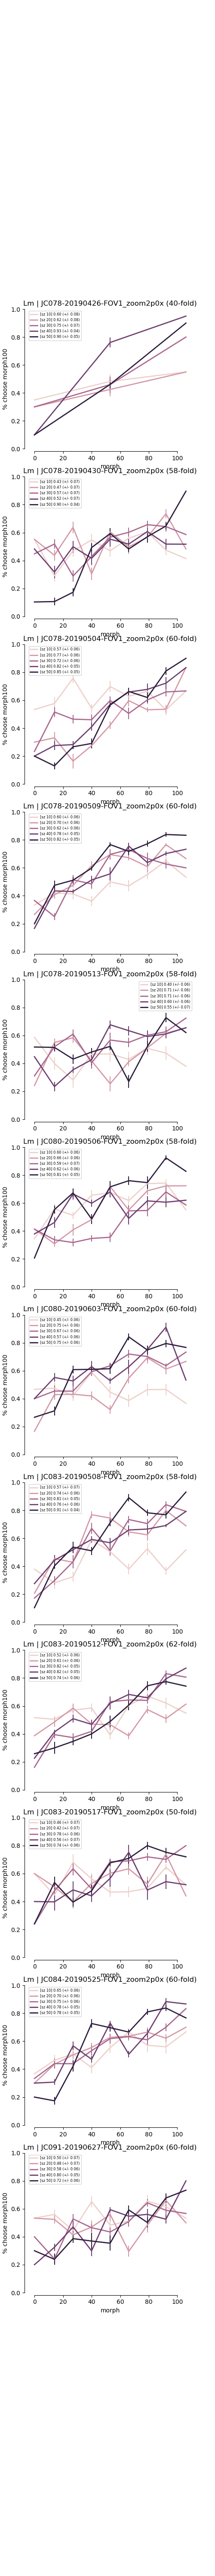

<IPython.core.display.Javascript object>


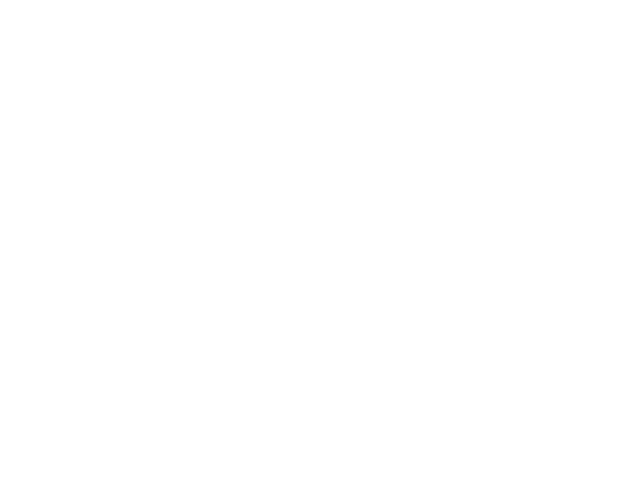

... [JC078|20190426|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC078-20190426-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 423.40
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 130 of 145 responsive cells.
mean score: 0.60 (+/- 0.08)
mean score: 0.62 (+/- 0.08)
mean score: 0.75 (+/- 0.07)
mean score: 0.93 (+/- 0.04)
mean score: 0.90 (+/- 0.05)
Lm_JC078-20190426-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


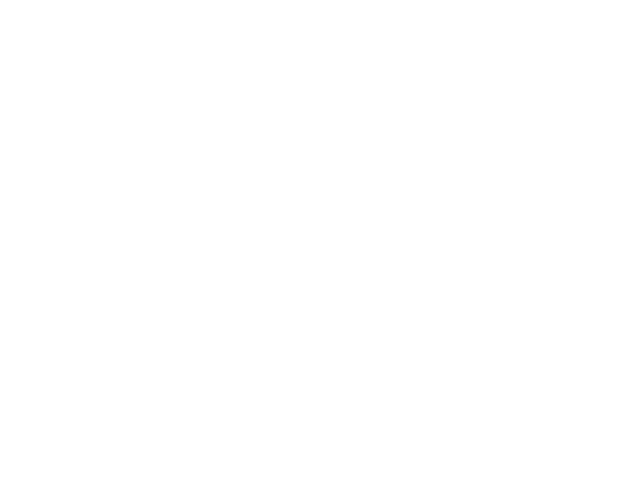

... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC078-20190430-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 629.71
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 89 of 101 responsive cells.
mean score: 0.43 (+/- 0.07)
mean score: 0.47 (+/- 0.07)
mean score: 0.57 (+/- 0.07)
mean score: 0.52 (+/- 0.07)
mean score: 0.90 (+/- 0.04)
Lm_JC078-20190430-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


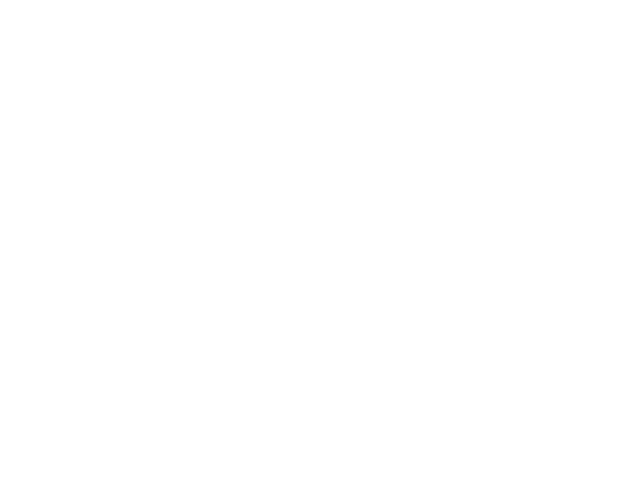

... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC078-20190504-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 368.74
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 78 of 87 responsive cells.
mean score: 0.57 (+/- 0.06)
mean score: 0.77 (+/- 0.06)
mean score: 0.72 (+/- 0.06)
mean score: 0.82 (+/- 0.05)
mean score: 0.85 (+/- 0.05)
Lm_JC078-20190504-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


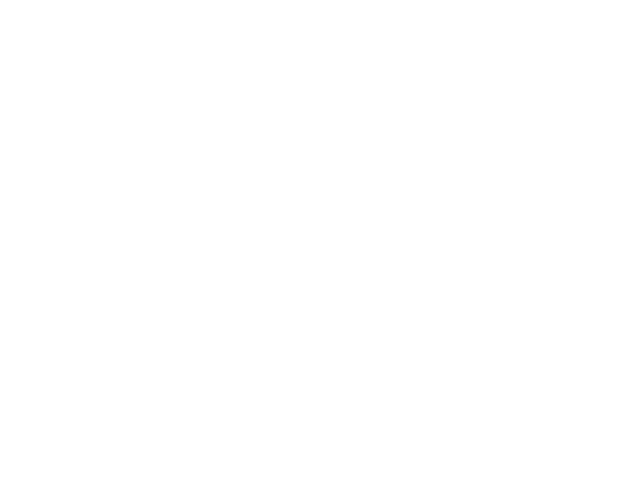

... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC078-20190509-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 329.04
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 60 of 69 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.70 (+/- 0.06)
mean score: 0.62 (+/- 0.06)
mean score: 0.78 (+/- 0.05)
mean score: 0.82 (+/- 0.05)
Lm_JC078-20190509-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


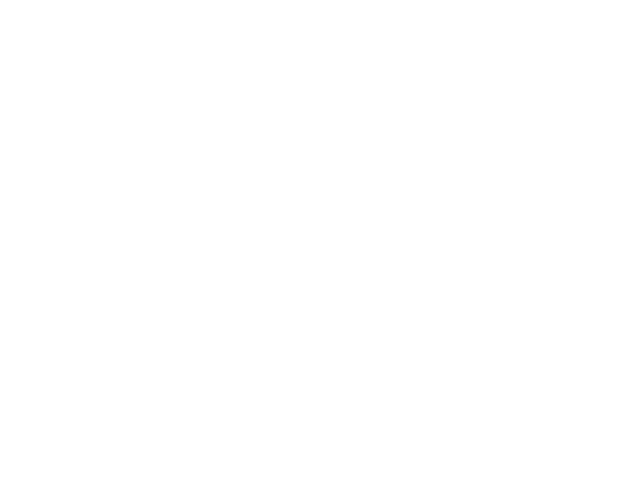

... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC078-20190513-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 422.91
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 61 of 68 responsive cells.
mean score: 0.40 (+/- 0.06)
mean score: 0.71 (+/- 0.06)
mean score: 0.71 (+/- 0.06)
mean score: 0.60 (+/- 0.06)
mean score: 0.55 (+/- 0.07)
Lm_JC078-20190513-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


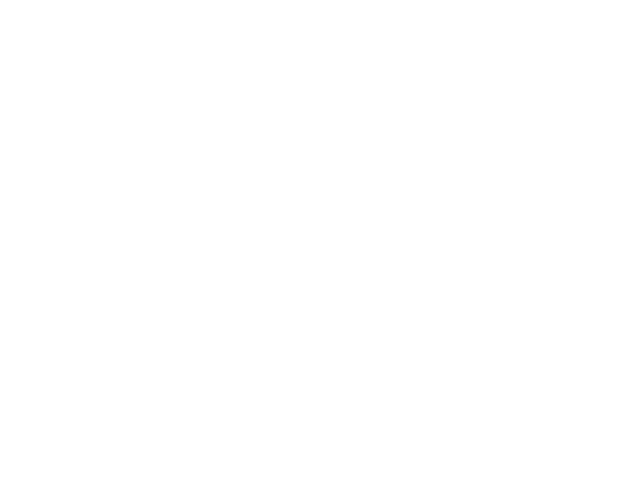

... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC080-20190506-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 423.89
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 140 of 146 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.66 (+/- 0.06)
mean score: 0.59 (+/- 0.07)
mean score: 0.62 (+/- 0.06)
mean score: 0.81 (+/- 0.05)
Lm_JC080-20190506-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


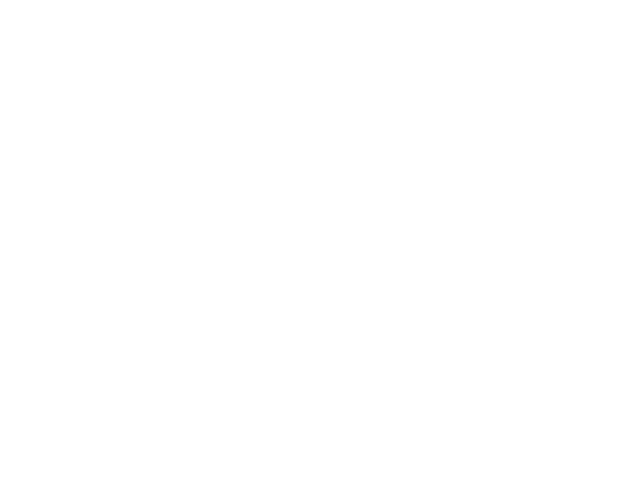

... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC080-20190603-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 573.12
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 111 of 122 responsive cells.
mean score: 0.45 (+/- 0.06)
mean score: 0.75 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.57 (+/- 0.06)
mean score: 0.75 (+/- 0.06)
Lm_JC080-20190603-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


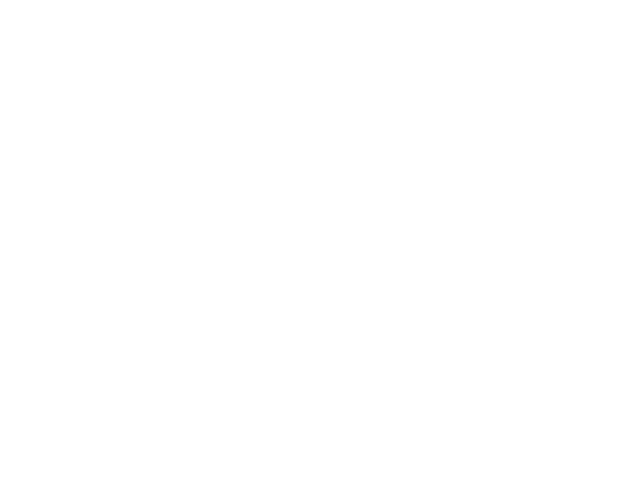

... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC083-20190508-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 516.48
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 95 of 122 responsive cells.
mean score: 0.57 (+/- 0.07)
mean score: 0.74 (+/- 0.06)
mean score: 0.81 (+/- 0.05)
mean score: 0.76 (+/- 0.06)
mean score: 0.91 (+/- 0.04)
Lm_JC083-20190508-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


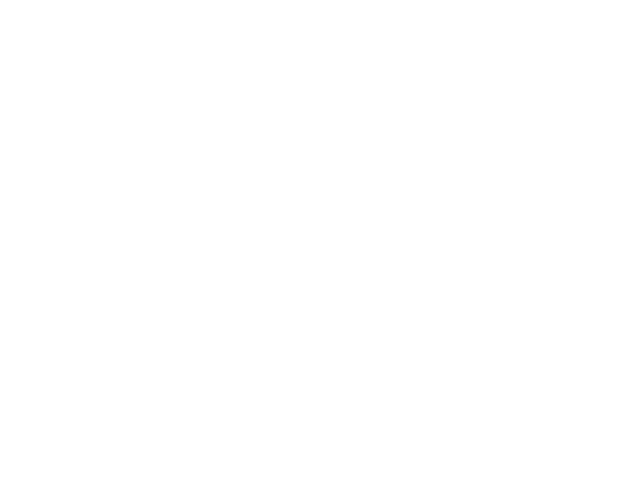

... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC083-20190512-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 582.17
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 89 of 114 responsive cells.
mean score: 0.52 (+/- 0.06)
mean score: 0.61 (+/- 0.06)
mean score: 0.82 (+/- 0.05)
mean score: 0.82 (+/- 0.05)
mean score: 0.74 (+/- 0.06)
Lm_JC083-20190512-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


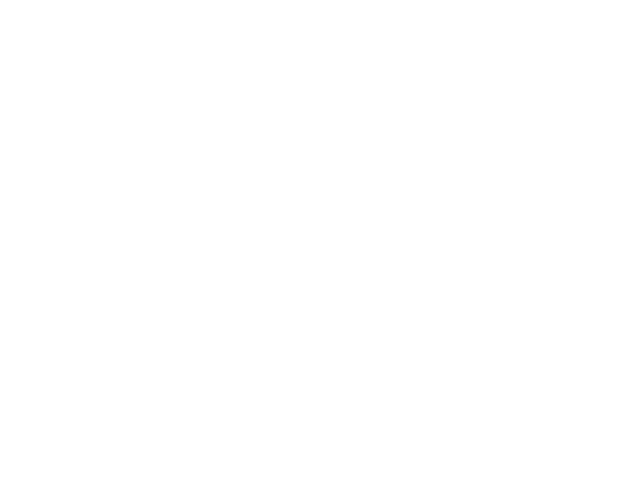

... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC083-20190517-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 501.39
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 60 of 78 responsive cells.
mean score: 0.46 (+/- 0.07)
mean score: 0.42 (+/- 0.07)
mean score: 0.78 (+/- 0.06)
mean score: 0.56 (+/- 0.07)
mean score: 0.74 (+/- 0.06)
Lm_JC083-20190517-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


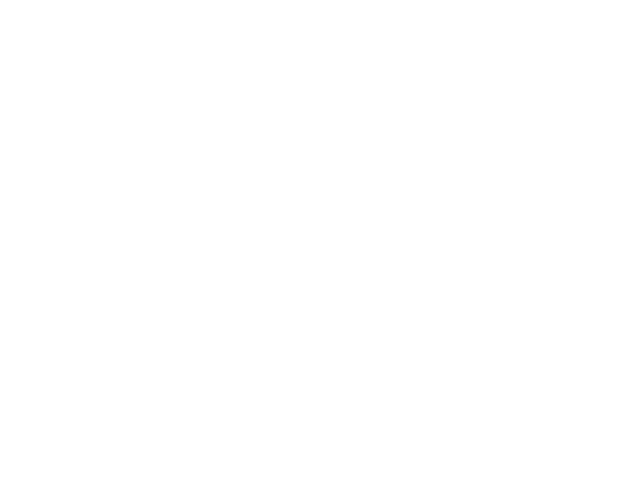

... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC084-20190525-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 289.08
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 85 of 90 responsive cells.
mean score: 0.65 (+/- 0.06)
mean score: 0.70 (+/- 0.06)
mean score: 0.75 (+/- 0.06)
mean score: 0.78 (+/- 0.05)
mean score: 0.78 (+/- 0.05)
Lm_JC084-20190525-FOV1_zoom2p0x_AvsB-linearSVM-LOO


<IPython.core.display.Javascript object>


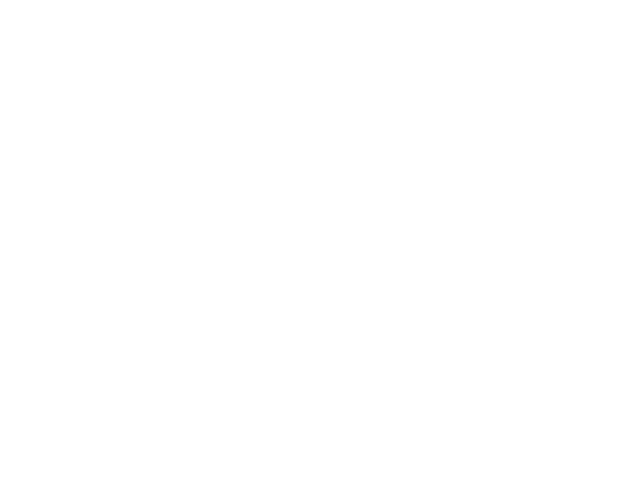

... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
Timecourse: Lm_JC091-20190627-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 363.42
... updating self
filtering responsive cells: ROC
... getting responsive cells (test: ROC, thr: 0.05')
Plotting 82 of 98 responsive cells.
mean score: 0.50 (+/- 0.07)
mean score: 0.48 (+/- 0.07)
mean score: 0.58 (+/- 0.06)
mean score: 0.80 (+/- 0.05)
mean score: 0.72 (+/- 0.06)
Lm_JC091-20190627-FOV1_zoom2p0x_AvsB-linearSVM-LOO


In [65]:


f2, axes = pl.subplots(n_datasets, figsize=(5, n_datasets*5))
f2.patch.set_alpha(1)

ai = 0
#ai = 0
for (animalid, session, fov), g in sessions.groupby(['animalid', 'session', 'fov']):
    ax2 = axes[ai]
    
    fig, ax = pl.subplots()
    fig.patch.set_alpha(1)
    
    skey = '-'.join([animalid, session, fov])
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)    
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    tested_sizes = np.array(sorted(sdf['size'].unique()))
    tested_morphs = np.array(sorted(sdf['morphlevel'].unique()))

    n_sizes = len(tested_sizes)
    n_morphs = len(tested_morphs)
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        pass

    trace_desc = '%s_%s-%s' % (skey, traceid, trace_type)
    tfilename = os.path.join(aggr_tcourse_dir, '%s_%s.pkl' % (visual_area, trace_desc))
    print("Timecourse: %s" % os.path.split(tfilename)[-1])
    #load_data=False
    try:
        with open(tfilename, 'rb') as f:
            exp = pkl.load(f)
            assert exp.data is not None and 'traces' in dir(exp.data)
            sdf = exp.data.sdf.copy()
    except Exception as e:
        load_data = True


        
    if load_data:
        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        with open(tfilename, 'wb') as f:
            pkl.dump(exp, f, protocol=pkl.HIGHEST_PROTOCOL)
        allstats[skey] = estats
                        
    meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T

    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
    print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))
    
    sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                          index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
    sample_data = sample_data[rois_plot]
    sample_labels = np.array(sample_data.index.tolist())


    stimdf = sdf[sdf['morphlevel'] != -1]

    #% Specify train/test conditions:     
    class_name = 'morphlevel'
    class_types = [0, 106]
    restrict_transform = True
    constant_transform = 'size'

    C = 1e3
    m0 = 0
    m100 = 106
    #fig, ax = pl.subplots()

    size_colors = sns.cubehelix_palette(len(tested_sizes))
    lw=2
    for curr_sz, curr_color in zip(tested_sizes, size_colors):
        
        if restrict_transform:
            constant_transform_val = curr_sz
            train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
        else:
            train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

        # Set train/test set:
        train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

        X = sample_data.iloc[train_ixs].values #[train_configs]
        y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

        # Set validation set:
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]==constant_transform_val) & (stimdf[class_name].isin(untrained_class_types)) )].index.tolist()
        test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
        X_test = sample_data.iloc[test_ixs].values
        y_test_labels = sample_labels[test_ixs]


        #% Train/test split
        n_splits = len(X)

        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)

        scores=[]
        test_scores = dict((stimdf[class_name][tc], []) for tc in test_configs)
        choices = dict((tc, []) for tc in tested_morphs)

        for train_index, validate_index in kf.split(X):
            # Get current train/test split data:
            X_train, X_validate = X[train_index], X[validate_index]
            y_train, y_validate = y[train_index], y[validate_index]
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train_transformed = scaler.transform(X_train)

            # Fit SVM:
            trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

            # Test:
            X_validate_transformed = scaler.transform(X_validate)
            curr_score = trained_svc.score(X_validate_transformed, y_validate)  
            y_pred = trained_svc.predict(X_validate_transformed)

            # Test 2:
            for true_val, pred_val in zip(y_validate, y_pred):
                choices[true_val].append(pred_val)

            for tc in test_configs:
                X_test_transformed = scaler.transform(X_test[np.where(y_test_labels==tc)[0], :])
                curr_score_test = trained_svc.score(X_test_transformed, [m100 for _ in range(X_test_transformed.shape[0])])  
                test_scores[stimdf[class_name][tc]].append(curr_score_test)
                y_pred_test = trained_svc.predict(X_test_transformed)

                choices[stimdf[class_name][tc]].append(y_pred_test)

            scores.append(curr_score)

        print("mean score: %.2f (+/- %.2f)" % (np.mean(scores), spstats.sem(scores)))
        #for k, v in sorted(test_scores.items(), key=lambda x: x[0]):
        #    print k, np.nanmean(v)

        #fig, ax = pl.subplots()
        pchoose100={}
        pchoose100_sem={}
        for k, v in choices.items():
            if k in [m0, m100]:
                pchoose100[k] = np.sum([i==m100 for i in v]) / float(len(v))
                pchoose100_sem[k] = 0
            else:
                pchoose100[k] = np.mean([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])
                pchoose100_sem[k] = np.std([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])


        curr_label = "[sz %i] %.2f (+/- %.2f)" % (curr_sz, np.mean(scores), spstats.sem(scores))
        for cax in [ax, ax2]:
            cax.plot(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())], '-', \
                    markersize=.5, lw=lw, color=curr_color, label=curr_label)
            cax.errorbar(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())],\
                        yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())], fmt='none',
                        ecolor=curr_color)

            cax.set_ylim([0, 1])
            cax.set_ylabel('% choose morph100')
            cax.set_xlabel('morph')
            cax.set_title('%s | %s (%i-fold)' % (visual_area, skey, n_splits))
            sns.despine(trim=True, offset=4, ax=cax)

    #pl.subplots_adjust(top=0.8)
    ax.legend(fontsize=6)
    ax2.legend(fontsize=6)

    pl.figure(fig.number)
    figname = '%s_%s_AvsB-linearSVM-LOO' % (visual_area, skey)
    pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
    pl.close()
    ai += 1
    print figname

pl.figure(f2.number)
figname = '%s_AvsB-linearSVM-LOO_all-datasets' % (visual_area)
pl.savefig(os.path.join(outdir, '%s.png' % figname))

with open(sfilename, 'wb') as f:
    pkl.dump(allstats, f, protocol=pkl.HIGHEST_PROTOCOL)


In [57]:
allstats

['JC076-20190422-FOV1_zoom2p0x',
 'JC090-20190605-FOV1_zoom2p0x',
 'JC091-20190602-FOV1_zoom2p0x',
 'JC099-20190612-FOV1_zoom2p0x',
 'JC076-20190502-FOV1_zoom2p0x',
 'JC099-20190609-FOV1_zoom2p0x',
 'JC091-20190614-FOV1_zoom2p0x',
 'JC091-20190606-FOV1_zoom2p0x',
 'JC091-20190607-FOV1_zoom2p0x',
 'JC099-20190617-FOV1_zoom2p0x']